In [28]:
import pandas as pd
import os, math
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np

class BytesDataset:
    def __init__(self, root_path, crop=0):
        self.root_path = root_path
        self.dataset_left_imgs = os.path.join(self.root_path, "left")
        self.dataset_right_imgs = os.path.join(self.root_path, "right")
        self.dataset_file = os.path.join(self.root_path, "db.csv")
        self.data = pd.read_csv(self.dataset_file, dtype={'stamp':str})
        self.breaks = self.data.index[self.data['stamp'] =='-']
        self.collisions = self.data.index[self.data['collision bool'] > 0.1]
        
        self.vertical_image_crop = crop
    
    def set_image_crop(crop):
        self.vertical_image_crop = crop
        
    def index_exists(self, index):
        return index < len(self.data) and index > -1 and self.data.iloc[index]['stamp'] != '-'
    
    def read_torch_image(self, index, right=False, augment=False):
        if self.index_exists(index):
            
            name = self.data.iloc[index]['stamp']
            if not "." in name:
                name += "."
            
            if right:
                img = plt.imread(os.path.join(self.dataset_right_imgs, name + ".jpg"))
            else:
                img = plt.imread(os.path.join(self.dataset_left_imgs, name + ".jpg"))
            return process_image(img, augment)[:,self.vertical_image_crop:,:]
        else:
            return torch.tensor([])

    def read_cv_image(self, index, right=False):
        if self.index_exists(index):
            
            name = self.data.iloc[index]['stamp']
            if not "." in name:
                name += "."
            
            if right:
                img = plt.imread(os.path.join( self.dataset_right_imgs, name + ".jpg"))
            else:
                img = plt.imread(os.path.join(self.dataset_left_imgs, name + ".jpg"))
            return img[self.vertical_image_crop:,:,:]
        else:
            return torch.tensor([])
    
    
    def get_position(self, index):
        if self.index_exists(index):
            return np.array([self.data.iloc[index]['position x'], self.data.iloc[index]['position y'], self.data.iloc[index]['position z']])
        else:
            return np.array([])
    
    def get_orientation(self, index):
        if self.index_exists(index):
            return np.array([self.data.iloc[index]['odom orientation z'], self.data.iloc[index]['odom orientation y'], self.data.iloc[index]['odom orientation x'], self.data.iloc[index]['odom orientation w']])
        else:
            return np.array([])
    
    def get_last_break(self, index):
        last_value = -1
        for value in self.breaks:
            if value <= index:
                last_value = value
            else:
                break
        return last_value
    
    def get_next_break(self, index):
        for value in self.breaks:
            if value >= index:
                return value
        return math.inf
    
    def is_near_collision(self, index, buffer):
        for value in self.collisions:
            if (value > index - buffer and value > self.get_last_break(index)) and (value < index + buffer and value < self.get_next_break(index)):
                return True
        return False
    
    def reference_target_from_source(self, source, target):
        if(self.get_next_break(source) > target):
            transformed_point = point_rotation_by_quaternion(subtract_points(self.get_position(source), self.get_position(target)), self.get_orientation(source))
            return np.array([-transformed_point[1], transformed_point[0], -transformed_point[2]])
        else:
            return np.array([])
    
    def path_source_to_target(self, source, target):
        path = np.array([[0,0,0]])
        for i in range(source+1, target+1):
            point = self.reference_target_from_source(source,i)
            if(len(point) > 0):
                path = np.append(path, [point], axis=0)
            else:
                return np.array([])
        return path
    
    
# Static helpers 
def torch_image_to_cv_image(image):
    npimg = image.numpy().copy()
    # unnormalize the image
    npimg[0] *= 0.229
    npimg[1] *= 0.224
    npimg[2] *= 0.225
    npimg[0] += 0.485
    npimg[1] += 0.456
    npimg[2] += 0.406
    npimg = np.transpose(npimg, (1,2,0))
    npimg = np.clip(npimg,0.0,1.0)
    return npimg


def process_image(img, augment=False):
    if augment:
        transform = transforms.Compose(
        [transforms.ColorJitter(0.5, 0.5, 0.5),
         transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
         transforms.ToTensor(),
         AddGaussianNoise(0, 0.01),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    else: 
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    img = transform(Image.fromarray(img))
    return img 

def quaternion_mult(q,r):
    return [r[0]*q[0]-r[1]*q[1]-r[2]*q[2]-r[3]*q[3],
            r[0]*q[1]+r[1]*q[0]-r[2]*q[3]+r[3]*q[2],
            r[0]*q[2]+r[1]*q[3]+r[2]*q[0]-r[3]*q[1],
            r[0]*q[3]-r[1]*q[2]+r[2]*q[1]+r[3]*q[0]]

# input point is [x,y,z] and quaternion is z, x, y, w
def point_rotation_by_quaternion(point,q):
    r = [0]+point
    q_conj = [q[0],-1*q[1],-1*q[2],-1*q[3]]
    return quaternion_mult(quaternion_mult(q,r),q_conj)[1:]

# point 1 - point 2
def subtract_points(point1, point2):
    return [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]

def project_to_image(position, vertical_crop=0, cameraMatrix=np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]]),\
                     tvec=np.float64([0.1485, 0.1, 0.1325]), rvec=np.float64([-1.5707963, 1.5707963, 0 ]), right=False):

    # dz can be used to account for vertical motion from the source frame
    if right:
        point = [position[0]-tvec[1], position[2] + tvec[1], position[1]+tvec[0]] 
    else:
        point = [position[0]+tvec[1], position[2] + tvec[1], position[1]+tvec[0]]

    reprojected_point = np.matmul(cameraMatrix, point)
    pt_x = int(reprojected_point[0]/reprojected_point[2])
    pt_y = int(reprojected_point[1]/reprojected_point[2])
    return np.array([pt_x, pt_y-vertical_crop])

def make_mask_from_path(path, vertical_crop=0, robot_width=0.6, step_height=0.2, image_shape=(180,320,3), right=False):
    mask = np.zeros(image_shape, dtype=np.float32)
    for point in path:    
        right_corner = project_to_image([point[0] - robot_width/2, point[1] - step_height/2, point[2]], right=right)
        left_corner = project_to_image([point[0] + robot_width/2, point[1] + step_height/2, point[2]], right=right)
        mask = cv2.rectangle(mask, (right_corner[0], right_corner[1]-vertical_crop), (left_corner[0], left_corner[1]-vertical_crop), (1.0, 1.0, 1.0), -1) 
    return mask

In [29]:
import utils
train_path = "/home/michael/Desktop/BytesDB_train_normal/"
test_normal_path = "/home/michael/Desktop/BytesDB_test_normal/"
test_anormal_path = "/home/michael/Desktop/BytesDB_test_anormal/"

## Using Pandas for Dataloading and Management, New Data Management Class

In [30]:
train_data =  utils.BytesDataset(train_path, crop=90)
test_normal_data  =  utils.BytesDataset(test_normal_path, crop=90)
test_anormal_data  =  utils.BytesDataset(test_anormal_path, crop=90)

In [31]:
train_path = "/home/michael/Desktop/BytesDB_train/"
test_path = "/home/michael/Desktop/BytesDB_valid/"

In [32]:
train_data = BytesDataset(train_path)
test_data = BytesDataset(test_path)

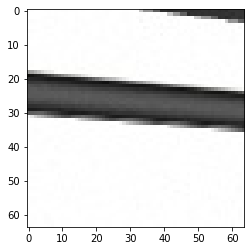

In [33]:
import matplotlib.pyplot as plt

plt.imshow(train_data.read_cv_image(5, right=True)[:64,:64,:])

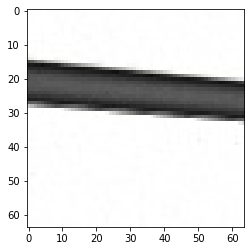

In [34]:
plt.imshow(train_data.read_cv_image(5, right=False)[:64,:64,:])

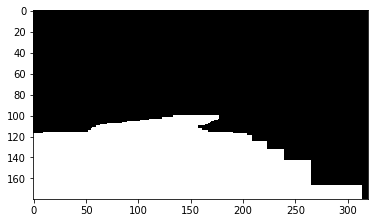

In [35]:
plt.imshow(make_mask_from_path(train_data.path_source_to_target(60, 90), right=True))

[-1412   483]
[313 167]

[-325  211]
[265 143]

[-141  164]
[239 132]

[-68 145]
[223 125]

[-18 131]
[208 119]

[ -2 127]
[203 117]

[ 10 124]
[190 116]

[ 23 124]
[178 116]

[ 33 123]
[177 116]

[ 43 123]
[176 116]

[ 53 119]
[166 114]

[ 55 116]
[160 112]

[ 56 115]
[157 111]

[ 59 114]
[156 111]

[ 60 114]
[155 110]

[ 64 112]
[155 109]

[ 68 112]
[155 109]

[ 71 111]
[156 108]

[ 72 111]
[157 108]

[ 72 111]
[157 108]

[ 85 109]
[162 107]

[ 90 109]
[163 106]

[ 96 108]
[166 106]

[102 107]
[168 105]

[105 106]
[169 105]

[111 105]
[172 104]

[123 104]
[176 102]

[127 103]
[177 102]

[128 103]
[177 102]

[134 101]
[177 100]

[134 101]
[176 100]



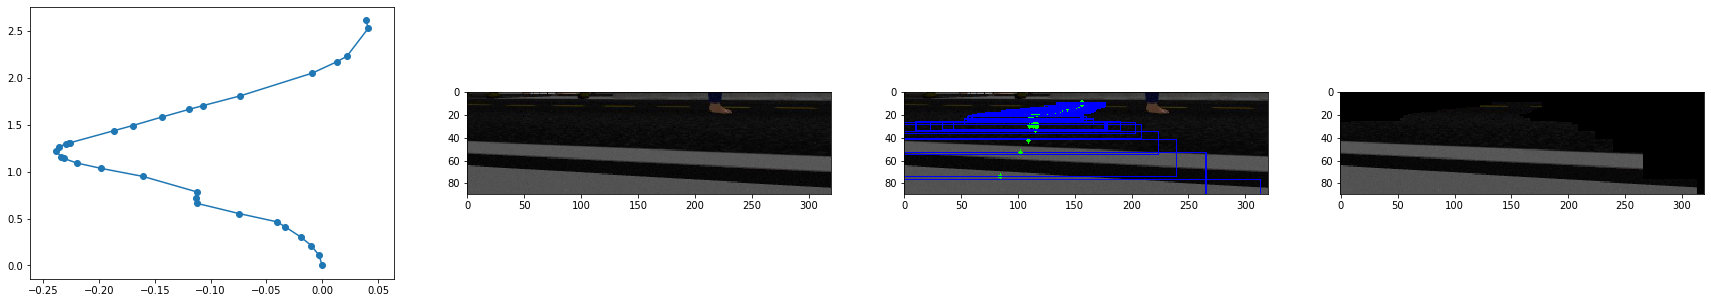

In [36]:
###### import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

source = 60
target = 90
robot_width = 0.6
crop_line = 90

image = train_data.read_cv_image(source, right=True)[crop_line:,:,:]
image_raw = image.copy()
path = train_data.path_source_to_target(source, target)

mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

for point in path:
    point_image =  project_to_image(point, right=True)
    image = cv2.circle(image, (point_image[0], point_image[1]-crop_line), 2, (0,255,0), -1) 
    
    right_corner =  project_to_image([point[0] - robot_width/2, point[1] - 0.1, point[2]], right=True)
    left_corner =  project_to_image([point[0] + robot_width/2, point[1] + 0.1, point[2]], right=True)
    
    print(right_corner)
    print(left_corner)
    print()
    
    image = cv2.rectangle(image, (right_corner[0], right_corner[1]-crop_line), (left_corner[0], left_corner[1]-crop_line), (0,0,255), 1) 
    
    mask = cv2.rectangle(mask, (right_corner[0], right_corner[1]-crop_line), (left_corner[0], left_corner[1]-crop_line), (255, 255, 255), -1) 
    
res = cv2.bitwise_and(image_raw, image_raw, mask=mask)
    
fig = plt.figure(figsize=(30,5))
fig.add_subplot(1,4,1)
plt.scatter(path[:,0], path[:,1])
plt.plot(path[:,0], path[:,1])
fig.add_subplot(1,4,2)
plt.imshow(image_raw)
fig.add_subplot(1,4,3)
plt.imshow(image)
fig.add_subplot(1,4,4)
plt.imshow(res)